<a href="https://colab.research.google.com/github/SrTorGonz/Homework-5/blob/main/VGG16_sin_ecualizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile

# Subir archivo comprimido (ZIP) que contenga Training/ y Testing/
uploaded = files.upload()

# Descomprimir (si el dataset está en ZIP)
with zipfile.ZipFile(list(uploaded.keys())[0], 'r') as zip_ref:
    zip_ref.extractall('/content')

train_dir = '/content/Training'  # Ajusta según la estructura exacta
test_dir = '/content/Testing'

Saving Brain Tumor MRI.zip to Brain Tumor MRI.zip


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
import numpy as np

# 1. Configuración GPU (ejecutar primero)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error GPU:", e)
        print("Reinicia el runtime (Runtime -> Restart runtime)")

# 2. Preprocesamiento mejorado para MRI
def enhanced_mri_preprocessing(image):
    """Preprocesamiento especializado para imágenes MRI cerebrales"""
    # Convertir a float32 y normalizar a [0,1]
    image = tf.cast(image, tf.float32)
    image = image / tf.reduce_max(image)

    # Convertir a RGB si es escala de grises
    if image.shape[-1] == 1:
        image = tf.repeat(image, 3, axis=-1)

    # Ecualización del histograma en cada canal (mejora contraste)
    #def clahe_channel(channel):
     #   channel = channel.numpy() * 255
      #  channel = channel.astype(np.uint8)
       # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        #return clahe.apply(channel) / 255.0

    #channels = tf.unstack(image, axis=-1)
    #channels = [clahe_channel(ch) for ch in channels]
    #image = tf.stack(channels, axis=-1)

    # Normalización específica para VGG16
    return preprocess_input(image * 255.0)  # preprocess_input espera [0,255]

# 3. Generadores de datos con aumento aumentado
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=enhanced_mri_preprocessing,
    rotation_range=15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

test_datagen = ImageDataGenerator(
    preprocessing_function=enhanced_mri_preprocessing
)

train_generator = train_datagen.flow_from_directory(
    '/content/Training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Testing',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 4. Modelo VGG16 mejorado
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(*TARGET_SIZE, 3)
)
base_model.trainable = False  # Congelar inicialmente

# Capas personalizadas mejoradas
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(base_model.input, output)

# 5. Compilación inicial
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Callbacks mejorados
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]


# 8. Fine-tuning (descongelar capas superiores)
print("\nFine-tuning de capas superiores")
for layer in base_model.layers[:15]:
  layer.trainable = False
for layer in base_model.layers[15:]:
  layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=1e-5),  # LR más bajo para fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history= model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=callbacks
)

# 9. Evaluación final
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nPrecisión Final con VGG16 mejorado: {test_acc:.2%}")

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

Fine-tuning de capas superiores
Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.3015 - loss: 2.6686

179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 768ms/step - accuracy: 0.3018 - loss: 2.6635 - val_accuracy: 0.6110 - val_loss: 1.0306 - learning_rate: 1.0000e-05
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.4796 - loss: 1.1402

179/179 ━━━━━━━━━━━━━━━━━━━━ 129s 719ms/step - accuracy: 0.4799 - loss: 1.1398 - val_accuracy: 0.6987 - val_loss: 0.7691 - learning_rate: 1.0000e-05
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.6566 - loss: 0.8475

179/179 ━━━━━━━━━━━━━━━━━━━━ 128s 715ms/step - accuracy: 0.6566 - loss: 0.8473 - val_accuracy: 0.7918 - val_loss: 0.5785 - learning_rate: 1.0000e-05
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.7427 - loss: 0.6530

179/179 ━━━━━━━━━━━━━━━━━━━━ 129s 719ms/step - accuracy: 0.7428 - loss: 0.6528 - val_accuracy: 0.8169 - val_loss: 0.5038 - learning_rate: 1.0000e-05
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.7962 - loss: 0.5328

179/179 ━━━━━━━━━━━━━━━━━━━━ 130s 724ms/step - accuracy: 0.7963 - loss: 0.5327 - val_accuracy: 0.8490 - val_loss: 0.4320 - learning_rate: 1.0000e-05
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.8291 - loss: 0.4532

179/179 ━━━━━━━━━━━━━━━━━━━━ 127s 710ms/step - accuracy: 0.8291 - loss: 0.4530 - val_accuracy: 0.8604 - val_loss: 0.3874 - learning_rate: 1.0000e-05
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.8627 - loss: 0.3910

179/179 ━━━━━━━━━━━━━━━━━━━━ 129s 720ms/step - accuracy: 0.8627 - loss: 0.3909 - val_accuracy: 0.8749 - val_loss: 0.3295 - learning_rate: 1.0000e-05
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.8771 - loss: 0.3445

179/179 ━━━━━━━━━━━━━━━━━━━━ 136s 763ms/step - accuracy: 0.8772 - loss: 0.3443 - val_accuracy: 0.8833 - val_loss: 0.3225 - learning_rate: 1.0000e-05
Epoch 9/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.8953 - loss: 0.2874

179/179 ━━━━━━━━━━━━━━━━━━━━ 137s 768ms/step - accuracy: 0.8953 - loss: 0.2874 - val_accuracy: 0.8955 - val_loss: 0.2843 - learning_rate: 1.0000e-05
Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 127s 709ms/step - accuracy: 0.9045 - loss: 0.2592 - val_accuracy: 0.9031 - val_loss: 0.2868 - learning_rate: 1.0000e-05
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.9204 - loss: 0.2460

179/179 ━━━━━━━━━━━━━━━━━━━━ 128s 718ms/step - accuracy: 0.9204 - loss: 0.2459 - val_accuracy: 0.9321 - val_loss: 0.2018 - learning_rate: 1.0000e-05
Epoch 12/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9332 - loss: 0.1939

179/179 ━━━━━━━━━━━━━━━━━━━━ 128s 716ms/step - accuracy: 0.9332 - loss: 0.1939 - val_accuracy: 0.9397 - val_loss: 0.1573 - learning_rate: 1.0000e-05
Epoch 13/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 712ms/step - accuracy: 0.9433 - loss: 0.1588 - val_accuracy: 0.9336 - val_loss: 0.1845 - learning_rate: 1.0000e-05
Epoch 14/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.9491 - loss: 0.1462

179/179 ━━━━━━━━━━━━━━━━━━━━ 129s 719ms/step - accuracy: 0.9491 - loss: 0.1462 - val_accuracy: 0.9550 - val_loss: 0.1255 - learning_rate: 1.0000e-05
Epoch 15/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 129s 720ms/step - accuracy: 0.9653 - loss: 0.1114 - val_accuracy: 0.9527 - val_loss: 0.1380 - learning_rate: 1.0000e-05
Epoch 16/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 129s 719ms/step - accuracy: 0.9655 - loss: 0.1007 - val_accuracy: 0.9519 - val_loss: 0.1420 - learning_rate: 1.0000e-05
Epoch 17/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.9709 - loss: 0.0856

179/179 ━━━━━━━━━━━━━━━━━━━━ 129s 719ms/step - accuracy: 0.9709 - loss: 0.0856 - val_accuracy: 0.9687 - val_loss: 0.0902 - learning_rate: 1.0000e-05
Epoch 18/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 709ms/step - accuracy: 0.9730 - loss: 0.0835 - val_accuracy: 0.9519 - val_loss: 0.1241 - learning_rate: 1.0000e-05
Epoch 19/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.9744 - loss: 0.0730

179/179 ━━━━━━━━━━━━━━━━━━━━ 129s 720ms/step - accuracy: 0.9744 - loss: 0.0730 - val_accuracy: 0.9748 - val_loss: 0.0796 - learning_rate: 1.0000e-05
Epoch 20/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 710ms/step - accuracy: 0.9765 - loss: 0.0754 - val_accuracy: 0.9565 - val_loss: 0.1286 - learning_rate: 1.0000e-05
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - accuracy: 0.9730 - loss: 0.0902

Precisión Final con VGG16 mejorado: 97.48%


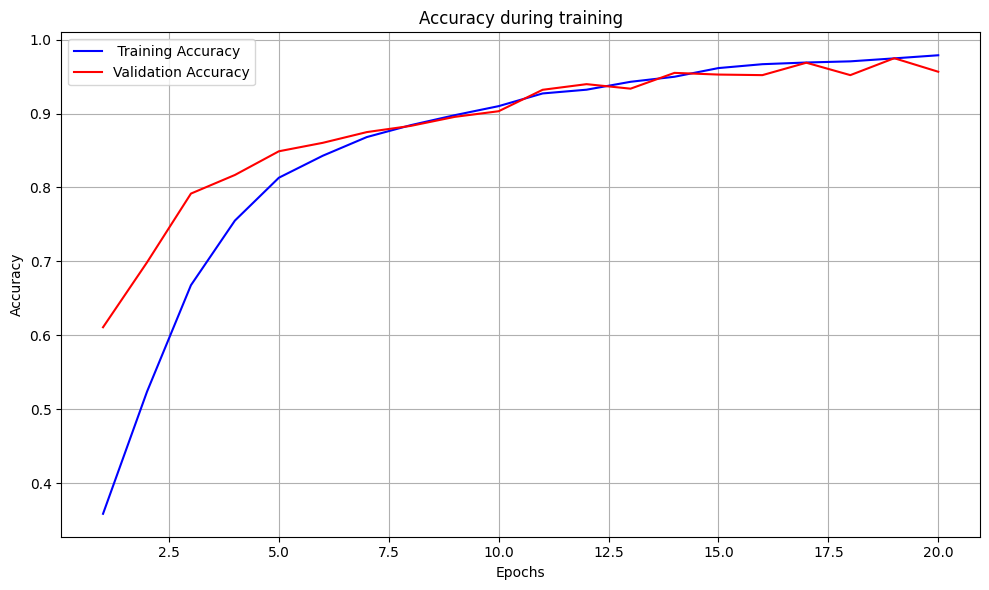

In [ ]:
import matplotlib.pyplot as plt

# Obtener métricas del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b-', label=' Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Nombres de las clases: ['glioma', 'meningioma', 'notumor', 'pituitary']

Evaluación detallada en el conjunto de test:
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 289ms/step - accuracy: 0.9730 - loss: 0.0902

Exactitud (Accuracy) en test: 0.9748
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 336ms/step - accuracy: 0.9730 - loss: 0.0902
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 321ms/step
Tamaño de y_true: 1311
Tamaño de y_pred_classes: 1311
Confusion matrix without normalization


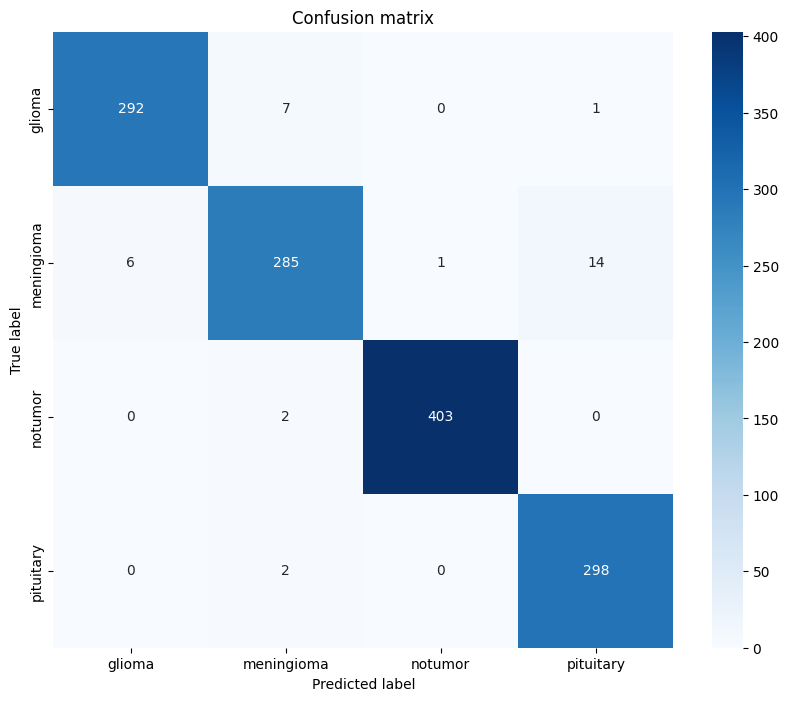


Reporte de Clasificación:
              precision    recall  f1-score   support

      glioma       0.98      0.97      0.98       300
  meningioma       0.96      0.93      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Primero obtenemos los nombres de las clases del generador de test
class_names = list(test_generator.class_indices.keys())
print("Nombres de las clases:", class_names)

# 2. Evaluar el modelo en el conjunto de test
print("\nEvaluación detallada en el conjunto de test:")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nExactitud (Accuracy) en test: {test_accuracy:.4f}")

# 3. Predecir las clases para el conjunto de test
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)

test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(f"Tamaño de y_true: {len(y_true)}")
print(f"Tamaño de y_pred_classes: {len(y_pred_classes)}")

# 4. Función para graficar matriz de confusión
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 5. Graficar matriz de confusión
plot_confusion_matrix(y_true, y_pred_classes, class_names, normalize=False)

# 6. Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))
